# Question Response Type Analysis
This notebook explores the data set constructed by Xin Li and Dan Roth, found [here](https://cogcomp.seas.upenn.edu/Data/QA/QC/). This data set examines various trivia/quiz questions with the intent of classifiying the type of response wanted. For example, if we looked at the question "Who was the president in 1846?" we intuitively know that the response should be a person. There are several different response categories such as description, entity, and location. In addition, each response category has several subcategories which get even more fine-grained. 

This is the type of problem that is relatively simple for a human to understand but somewhat difficult for a computer; using the above example, the words *who* and *the president* clue us in that the question is looking for an individual human. However, the word *who* can be used for several types of responses - "Who started World War 2" is ambiguous but could also refer to a country as well as a person. The *What* keyword adds to this ambiguity even further, as we could have questions like "What tree flowers in the spring?" or "What caused the Great Depression". 

While this is a difficult problem, it is an extremely relevant one - especially for a company like 98point6. Since users are texting with a doctor, our end goal as the data science team is to help doctors see more patients. Using a framework like this, we could potentially identify the type of response wanted by the patient and automatically pull up appropriate documentation for the provider. We could also queue up sample responses which might provide templates for provider responsees - this would save time typing and allow the provider to keep their focus on the patients.

With the problem described and the value explained we can begin our analysis. We will start by setting up the data, then move into some basic exploratory data analysis and modeling. The data can be found in the **data** folder, and we will be using the train_* file to train our model and examine our results on the holdout set. Our utility code (which doesn't really belong in a notebook) is found in **utils.py**.

Also, this repository contains a devcontainer folder that can be used to recreate the docker image which was used to run this code. This should make this notebook re-runnable (though depending on how long some of this takes to run that might not be advisable).

In [146]:
# imports
# show all jupyter notebook output 
# (shoutout to this stack overflow page, I use this in literally every notebook: 
# https://stackoverflow.com/questions/36786722/how-to-display-full-output-in-jupyter-not-only-last-result )
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# autoreload (essential when using a utility file)
%load_ext autoreload
%autoreload 2

# standard ds imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt

# data loading import
import src.data as data_load

# utils import
from utils import most_popular_words

# sklearn imports
import sklearn

# model saving
import joblib

# metrics
from sklearn.metrics import make_scorer, roc_auc_score, balanced_accuracy_score, accuracy_score

# model selection
from sklearn.model_selection import cross_validate, train_test_split

# preprocessing
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

# model composition
from sklearn.pipeline import Pipeline

# models
from sklearn.ensemble import RandomForestClassifier

# xgboost imports

# nltk imports
from nltk.tokenize import word_tokenize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now that our imports are out of the way, let's load up our data and get a handle on its size.

In [11]:
training = data_load.load("data/train_5500.label.txt")
holdout = data_load.load("data/test_TREC_10.label.txt")

print(f"Training size: {training.shape}")
training.head()
print(f"Test size: {holdout.shape}")

Training size: (5452, 3)


,question,fine_category,coarse_category
0,How did serfdom develop in and then leave Russ...,DESC:manner,DESC
1,What films featured the character Popeye Doyle ?,ENTY:cremat,ENTY
2,How can I find a list of celebrities ' real na...,DESC:manner,DESC
3,What fowl grabs the spotlight after the Chines...,ENTY:animal,ENTY
4,What is the full form of .com ?,ABBR:exp,ABBR


Test size: (500, 3)


In [44]:
training["coarse_category"].value_counts()
training["coarse_category"].value_counts() / training["coarse_category"].value_counts().sum()

ENTY    1250
HUM     1223
DESC    1162
NUM      896
LOC      835
ABBR      86
Name: coarse_category, dtype: int64

ENTY    0.229274
HUM     0.224321
DESC    0.213133
NUM     0.164343
LOC     0.153155
ABBR    0.015774
Name: coarse_category, dtype: float64

Looks like we have almost 5500 training samples in our data set. I'd love to have more, but based on the paper published by Li and Roth about this data set this sample size should be enough. Interestingly, they were able to acheive very high accuracy - I think this is because the questions in this data set are both manually cleaned and manually labeled. This cleanliness gives the model grammatical structures to work with, and so it can learn these structures just like we as humans do. I hypothesize that a model trained on this data set would only be marginally effective to real-world data entered by customers, as they would be full of misspellings and potentially bad grammar or slang. 

## EDA
We will be starting by exploring the coarse category. To get a handle on this data, there are a few things I would like to examine:
* Most popular words in all questions (and how they intersect with standardly accepted stop words)
* Most popular words per coarse category

Before we do any of that, we need to tokenize our data set. This will be done using nltk.

In [17]:
training["question"][4]
word_tokenize(training["question"][4])

'What is the full form of .com ?'

['What', 'is', 'the', 'full', 'form', 'of', '.com', '?']

In [19]:
training["question_tokenized"] = training["question"].apply(word_tokenize)
training["question_tokenized"].head()

0    [How, did, serfdom, develop, in, and, then, le...
1    [What, films, featured, the, character, Popeye...
2    [How, can, I, find, a, list, of, celebrities, ...
3    [What, fowl, grabs, the, spotlight, after, the...
4             [What, is, the, full, form, of, .com, ?]
Name: question_tokenized, dtype: object

Now that we have our tokenization, we can examine some information about it. First, what are the most popular words overall?

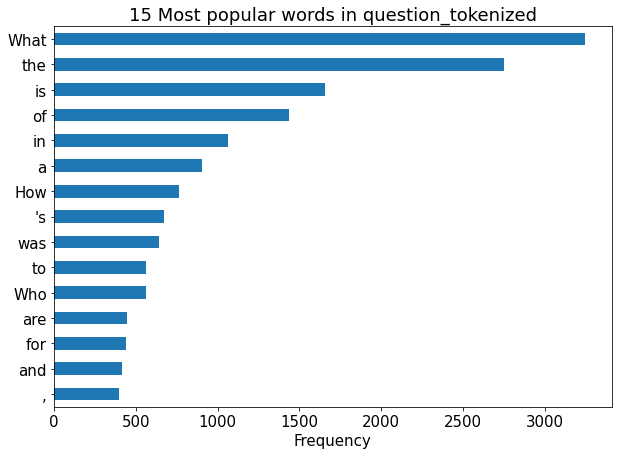

In [58]:
most_popular_words(training, "question_tokenized", n=15)

This isn't too surprising - *What*, *How*, *Who*, and then what we would normally consider stopwords. This brings up an interesting point regarding stop words. In normal NLP applications, we would want to filter them out since they don't provide much value (and indeed, in our first basic model, we likely will filter them out). However, they do provide context about the subject of the sentence, and thus because of the way questions are structured in the English language they provide context about the response. We likely won't filter them out in the final model.

Let's group by our coarse_category and look at the top few words for each.

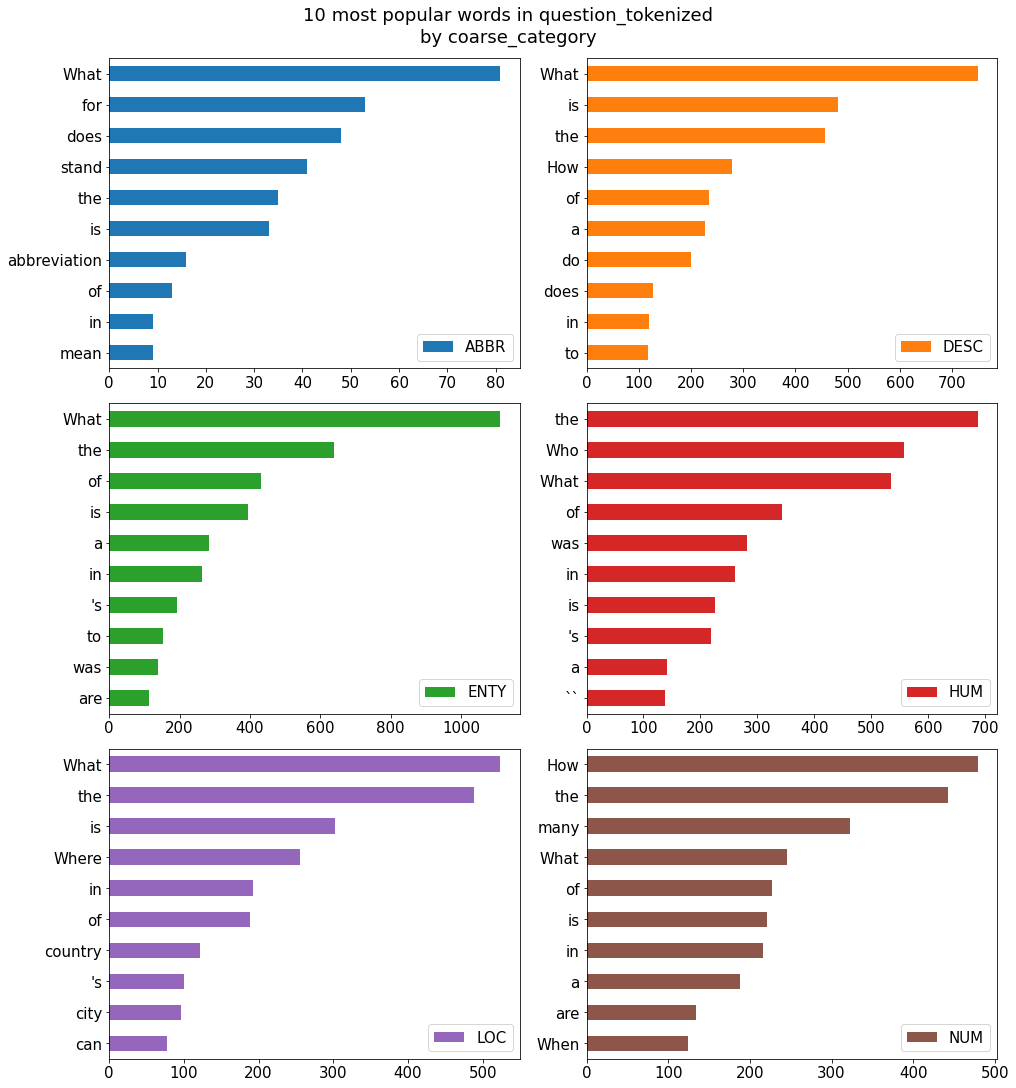

In [70]:
most_popular_words(training, "question_tokenized", grouping_col="coarse_category")

Offensive color scheme aside, this plot is extremely informative. For instance, the *NUM* category has *How*, *many* and *of*, giving a good indication of the phrases used. *LOC* has *What*, *Where*, and *country*, and the trend continues. This gives me a bit of hope that a simple bag-of-words model might not be absolutely awful. On that note let's move into modeling.
## Modeling
We will start with a bag-of-words representation model and use that as our baseline.

In [89]:
# we want a fairly simple vectorizer
vectorizer = CountVectorizer(min_df=0.0)
model = RandomForestClassifier(n_estimators=200, max_depth=10)

simple_pipe = Pipeline([
    ("feature_extraction", vectorizer),
    ("model", model)
])

In [111]:
scoring = ["balanced_accuracy", "roc_auc_ovr_weighted", "accuracy"]
cross_validate(simple_pipe, training["question"], training["coarse_category"], cv=5, scoring=scoring)

{'fit_time': array([0.53998852, 0.57100177, 0.60437822, 0.55600286, 0.52033734]),
 'score_time': array([0.10957789, 0.10896826, 0.12555408, 0.10302687, 0.10327601]),
 'test_balanced_accuracy': array([0.53696291, 0.52187315, 0.51688507, 0.54673472, 0.51236709]),
 'test_roc_auc_ovr_weighted': array([0.93245331, 0.92025738, 0.92119159, 0.92380462, 0.91596411]),
 'test_accuracy': array([0.64619615, 0.63428048, 0.62844037, 0.65779817, 0.62110092])}

Now this is some nice results - looks like we are classifying about 65% of the data set correctly (the accuracy) and our one-vs-rest C-stat is really nice as well. However, a single stat isn't extremely helpful when looking at multiclass, so let's dive into the confusion matrix. To do that, we will create a random 20% test set from the training set and examine it.

In [114]:
X_train, X_test, y_train, y_test = train_test_split(training["question"], training["coarse_category"], test_size=0.2)
X_train.shape
X_test.shape

(4361,)

(1091,)

In [115]:
# fit the model
simple_pipe.fit(X_train, y_train)

# make predictions
preds = simple_pipe.predict(X_test)
preds_proba = simple_pipe.predict_proba(X_test)

Pipeline(steps=[('feature_extraction', CountVectorizer(min_df=0.0)),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=200))])

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

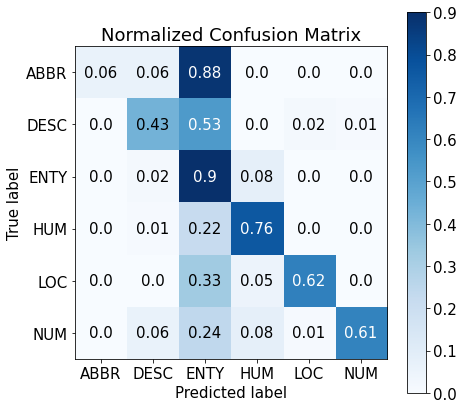

In [117]:
skplt.metrics.plot_confusion_matrix(y_test, preds, normalize=True, figsize=(7,7))

For the more populous columns, we did pretty well! We especially did well with entity - but, that happened at the cost of overpredicting the entity class like crazy. I'm curious what the actual numbers are:

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

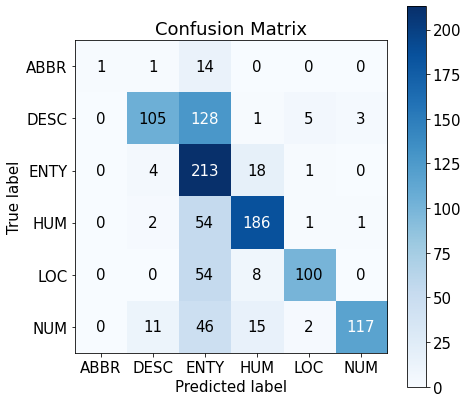

In [118]:
skplt.metrics.plot_confusion_matrix(y_test, preds, figsize=(7,7))

A sizeable portion of the data set was given to the entity class, but we still were able to discern most of the classes. The description vs entity issue also makes sense - let's examine a couple:

In [122]:
training[training["coarse_category"] == "DESC"]["question"].head(4).tolist()
training[training["coarse_category"] == "ENTY"]["question"].head(4).tolist()

['How did serfdom develop in and then leave Russia ?',
 "How can I find a list of celebrities ' real names ?",
 'What are liver enzymes ?',
 'Why do heavier objects travel downhill faster ?']

['What films featured the character Popeye Doyle ?',
 'What fowl grabs the spotlight after the Chinese Year of the Monkey ?',
 'What is considered the costliest disaster the insurance industry has ever faced ?',
 'What articles of clothing are tokens in Monopoly ?']

Look at the third DESC question - that isn't too different from the entity questions. Regardless, let's train this model on the entire data set so we can use it later and test out one other model.

In [134]:
simple_pipe.fit(training["question"], training["coarse_category"])
joblib.dump(simple_pipe, "models/simple_pipe_bow_v1.joblib")

Pipeline(steps=[('feature_extraction', CountVectorizer(min_df=0.0)),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=200))])

['models/simple_pipe_bow_v1.joblib']

CountVectorizer also gives us a nice interface to generate n-grams - I will use this to create additional features. To accomodate the additional feature space, we will up the number of estimators and their max depth. There are a million parameters we could change for this, but I don't think we will get to a full grid search with this analysis.

In [132]:
# we want a fairly simple vectorizer
vectorizer = CountVectorizer(min_df=0.0, ngram_range=(1,3))
model = RandomForestClassifier(n_estimators=300, max_depth=20)

simple_ngram_pipe = Pipeline([
    ("feature_extraction", vectorizer),
    ("model", model)
])

In [133]:
scoring = ["balanced_accuracy", "roc_auc_ovr_weighted", "accuracy"]
cross_validate(simple_ngram_pipe, training["question"], training["coarse_category"], cv=5, scoring=scoring)

{'fit_time': array([1.66162825, 1.76635528, 1.68451929, 1.75719881, 1.62318158]),
 'score_time': array([0.21916199, 0.23602629, 0.21118236, 0.20767879, 0.20538878]),
 'test_balanced_accuracy': array([0.62852409, 0.59502195, 0.67303845, 0.62348687, 0.5931783 ]),
 'test_roc_auc_ovr_weighted': array([0.94971194, 0.93806462, 0.9380585 , 0.93716936, 0.93348181]),
 'test_accuracy': array([0.73877177, 0.68102658, 0.73669725, 0.71651376, 0.70917431])}

This is a fairly significant increase in our metrics! At least our accuracy metrics. To share a secret, I played around a bit with the different parameters for our model. I originally wanted to set the min_df parameter in the vectorizer to exclude some extremely rare features, but this tanked the performance - I might have set it too high, but I imagine certain classes have very predictive features that might get cut out when making that kind of adjustment. While I think the ngrams helped, the biggest change came when I increased the max depth of each tree. Because the number of features is much greater than the number of samples, I have a feeling the learners need more depth to actually learn from these complex features, especially the interactions between them. Let's check out our confusion matrix.

In [135]:
# fit the model
simple_ngram_pipe.fit(X_train, y_train)

# make predictions
preds = simple_pipe.predict(X_test)
preds_proba = simple_pipe.predict_proba(X_test)

Pipeline(steps=[('feature_extraction',
                 CountVectorizer(min_df=0.0, ngram_range=(1, 3))),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=300))])

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

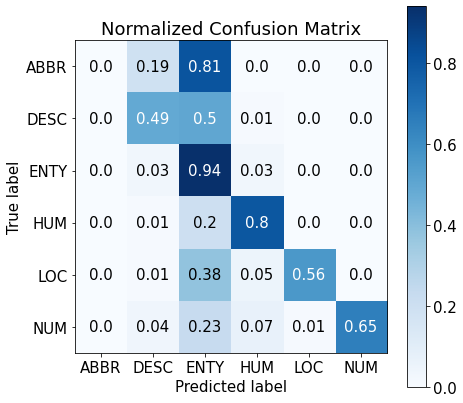

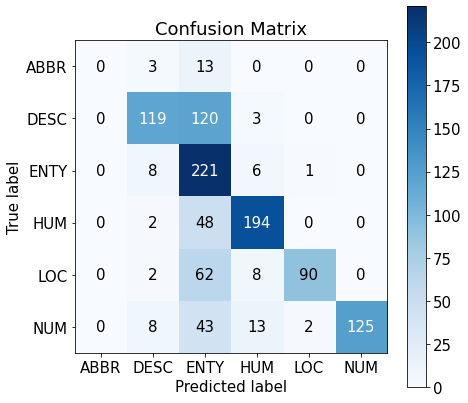

In [136]:
skplt.metrics.plot_confusion_matrix(y_test, preds, normalize=True, figsize=(7,7))
skplt.metrics.plot_confusion_matrix(y_test, preds, figsize=(7,7))

Looks like the ngrams increased the model's power to discern between entity and others, and also increased its ability for the human and number classes as well. Overall, I think this is better model. Now let's train this on the entire data set, save it, and perform one last test - I want to see if the max_depth increase improves performance in the original model.

In [138]:
simple_ngram_pipe.fit(training["question"], training["coarse_category"])
joblib.dump(simple_ngram_pipe, "models/simple_pipe_ngram_v1.joblib")

Pipeline(steps=[('feature_extraction',
                 CountVectorizer(min_df=0.0, ngram_range=(1, 3))),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=300))])

['models/simple_pipe_ngram_v1.joblib']

In [139]:
# we want a fairly simple vectorizer
vectorizer = CountVectorizer(min_df=0.0)
model = RandomForestClassifier(n_estimators=200, max_depth=20)

simple_pipe = Pipeline([
    ("feature_extraction", vectorizer),
    ("model", model)
])

In [141]:
scoring = ["balanced_accuracy", "roc_auc_ovr_weighted", "accuracy"]
cross_validate(simple_pipe, training["question"], training["coarse_category"], cv=5, scoring=scoring)

{'fit_time': array([0.85801959, 0.9039793 , 0.88328266, 0.88266659, 0.88379931]),
 'score_time': array([0.13120914, 0.12344098, 0.12031722, 0.12718511, 0.13147831]),
 'test_balanced_accuracy': array([0.68436995, 0.65420385, 0.65027209, 0.68208537, 0.66907189]),
 'test_roc_auc_ovr_weighted': array([0.94690603, 0.93117866, 0.93319389, 0.9390613 , 0.9276585 ]),
 'test_accuracy': array([0.71127406, 0.71402383, 0.68899083, 0.74678899, 0.71651376])}

Yep, that's what I thought. Let's save this and move into comparisons of the different models on the holdout. 

In [142]:
simple_pipe.fit(training["question"], training["coarse_category"])
joblib.dump(simple_pipe, "models/simple_pipe_bow_v2.joblib")

Pipeline(steps=[('feature_extraction', CountVectorizer(min_df=0.0)),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=200))])

['models/simple_pipe_bow_v2.joblib']

## Model Comparison
Let's load up the three models and see which one performs best on the holdout set.

In [143]:
bow_v1 = joblib.load("models/simple_pipe_bow_v1.joblib")
bow_v2 = joblib.load("models/simple_pipe_bow_v2.joblib")
ngram_v1 = joblib.load("models/simple_pipe_ngram_v1.joblib")

In [144]:
preds_bow_v1 = bow_v1.predict(holdout["question"])
preds_bow_v2 = bow_v2.predict(holdout["question"])
preds_ngram_v1 = ngram_v1.predict(holdout["question"])

In [149]:
y_true = holdout["coarse_category"]
balanced_accuracy_score(y_true, preds_bow_v1)
balanced_accuracy_score(y_true, preds_bow_v2)
balanced_accuracy_score(y_true, preds_ngram_v1)

0.429625169579662

0.7300883533035015

0.6182383411882483

In [153]:
accuracy_score(y_true, preds_bow_v1)
accuracy_score(y_true, preds_bow_v2)
accuracy_score(y_true, preds_ngram_v1)

0.446

0.756

0.732

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

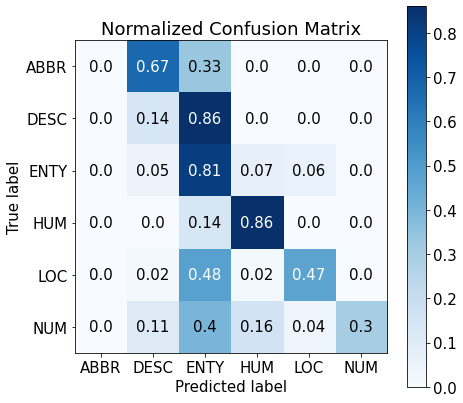

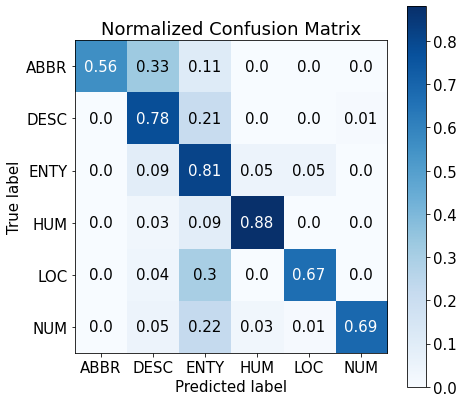

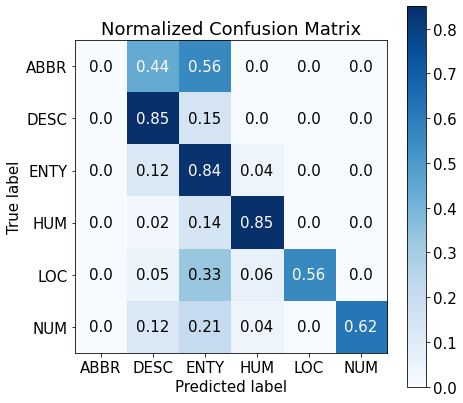

In [154]:
skplt.metrics.plot_confusion_matrix(y_true, preds_bow_v1, normalize=True, figsize=(7,7))
skplt.metrics.plot_confusion_matrix(y_true, preds_bow_v2, normalize=True, figsize=(7,7))
skplt.metrics.plot_confusion_matrix(y_true, preds_ngram_v1, normalize=True, figsize=(7,7))

Whew that was a lot of metrics. Either way, the clear winner is the v2 version of the bag-of-words model. It predicts all classes fairly well, and while the ABBR class is extremely small it still makes a reasonable attempt at predicting it (unlike the other models). I think the confusion matrix is key here, as it gives us a good picture of how the models skew towards the different classes. If I were to deploy one of these three models based on this training and test set I would choose the second model.

## Future Work
Due to the four hour time limit, I wasn't able to explore several avenues that I think could be extremely beneficial to this problem. For one thing, we didn't do any POS tagging which has a major impact on the subject of a question. This would be the direction that I would take this project, as I would anticipate major gains from those features. In addition, we don't do any stop word filtering, proper noun categorization, etc which might be useful.

Additionally, we only used a random forest model here - while this generally does pretty well, there might be other model structures that would work better. Specifically I would like to test out XGBoost (does well in pretty much every context) and a deep learning model. Deep learning would be especially effective here - there are many pre-trained NLP models that could be utilized for this task using transfer learning. Essentially, we would use the lower layers of the pretrained neural net as a base, and add a couple of layers after. These layers would use the features constructed by the lower layers to do our predictions, essentially taking the place of POS tagging, cleaning, etc. The reason I didn't start with this is that it's a massive pain to set up without a dedicated environment and my GPU has had problems with it previously.

As for model improvement, there are two avenues that I would take - more data is always good, though I don't think it would really give us much more improvement to the coarse categories. It's possible that for the finer-grained target it would help (which I wasn't able to get to due to the time limit) but I think ultimately the best thing we could do for this project would be feature engineering in the form of POS tagging and using a pre-trained deep learning model. The feature engineering would allow us to represent more of the structure of the sentence to the model, allowing it more avenues to learn. The pre-traine DL model would impose english language structure in a similar format and would give us the added advantage of identifying similar words and phrases; using word and phrase similarity is what gave the original writers the best performance and I think it could greatly improve our performance here.

Finally, if this analysis was exploration for a new project at 98point6, the main thing I would be interested in is how similar our patient/provider interactions actually are to this data set. I imagine that we wouldn't have the benefit of clean grammar and proper spelling, so even moreso we would need to rely on a pretrained model designed to handle such things. However, this would give us a good basis to do some semi-supervised learning (since we likely wouldn't have explicit target labels from our patient interaction data sets).